<a href="https://colab.research.google.com/github/NahuelCostaCortez/InteligeciaNegocio/blob/main/embeddings_analisis_sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*En este cuaderno se resuelve un problema de clasificación binaria de sentimiento a partir de datos de reviews de películas. Se utilizarán embeddings para obtener una representación vectorial de los datos donde palabras similares se mantengan en zonas cercanas de la representación interna del modelo (espacio latente).*

## Carga de datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pip install tensorflow-hub
# pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSH682B/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSH682B/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSH682B/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Cada ejemplo es una frase que representa la crítica de la película y una etiqueta correspondiente (0 si es una reseña negativa y 1 si es una reseña positiva)

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Entrenamiento del modelo

En lugar de aprender el embedding desde cero, podemos utilizar un embedding ya pre-entrenado, lo cual permite:



*   No preocuparse del preprocesamiento del texto (no tokenization, normalization, one-hot encoding...)
*   Aprovechar el aprendizaje de un modelo ya entrenado (Transfer Learning)

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 5s 77ms/step - loss: 0.6365 - accuracy: 0.5622 - val_loss: 0.5912 - val_accuracy: 0.6076
Epoch 2/10
30/30 [==============================] - 2s 59ms/step - loss: 0.5240 - accuracy: 0.7164 - val_loss: 0.4852 - val_accuracy: 0.7686
Epoch 3/10
30/30 [==============================] - 2s 59ms/step - loss: 0.3955 - accuracy: 0.8293 - val_loss: 0.3942 - val_accuracy: 0.8297
Epoch 4/10
30/30 [==============================] - 2s 58ms/step - loss: 0.2898 - accuracy: 0.8899 - val_loss: 0.3419 - val_accuracy: 0.8486
Epoch 5/10
30/30 [==============================] - 2s 60ms/step - loss: 0.2149 - accuracy: 0.9236 - val_loss: 0.3160 - val_accuracy: 0.8599
Epoch 6/10
30/30 [==============================] - 2s 60ms/step - loss: 0.1618 - accuracy: 0.9505 - val_loss: 0.3051 - val_accuracy: 0.8677
Epoch 7/10
30/30 [==============================] - 2s 58ms/step - loss: 0.1208 - accuracy: 0.9650 - val_loss: 0.3020 - val_accuracy: 0.8692
Epoch 8/10
30

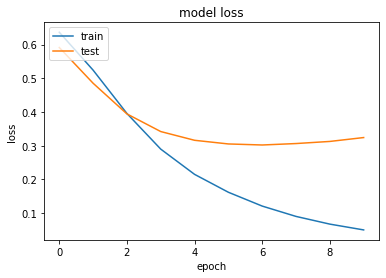

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_data.batch(512), verbose=2)

49/49 - 2s - loss: 0.3445 - accuracy: 0.8566 - 2s/epoch - 33ms/step


[0.34447628259658813, 0.8566399812698364]

## Predicciones

In [ ]:
predictions = model.predict(test_data.batch(512))

49/49 [==============================] - 1s 23ms/step


In [ ]:
 # cambiar para ver las predicciones para distintas reviews
sentence_index = 5
sentence = next(iter(train_data.batch(10)))[0][sentence_index]
sentence

<tf.Tensor: shape=(), dtype=string, numpy=b"This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl, its causes and its symptoms. The girl is played by one of the most brilliant young actresses working in cinema today, Alison Lohman, who was later so spectacular in 'Where the Truth Lies'. I would recommend that this film be shown in all schools, as you will never see a better on this subject. Alison Lohman is absolutely outstanding, and one marvels at her ability to convey the anguish of a girl suffering from this compulsive disorder. If barometers tell us the air pressure, Alison Lohman tells us the emotional pressure with the same degree of accuracy. Her emotional range is so precise, each scene could be measured microscopically for its gradations of trauma, on a scale of rising hysteria and desperation which reaches unbearable intensity. Mare Winn

In [ ]:
preds_sentence = "Positive" if predictions[sentence_index] == 1 else "Negative"
print("\nPrediction:", preds_sentence)


Prediction: Negative


In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>